# Learning non-linear model dynamics from data using Dynamic Mode Decomposition  
Ayush Gaggar  
J.D. Peiffer  


## Introduction  
Even with knowledge of a nonlinear system, modeling that system can be a quite difficult. Further, many nonlinear systems are functions of unknown inputs, or we may not be able to determine the inner workings of the model. However, this course has evidenced that it is not necessary to devolop a full model of the system to predict its behaivor, simply observing it gives us data to train different machine learning paradigms to approximate the unknown model's behavior.  

This project uses Dynamic Mode Decomposition (DMD) to exploit low-dimensionality in recorded data without having to learn a set of equations governing some example non-linear systems. We then experiment with different inputs to the DMD algorithm and their effect on the "learnability" of the system.  

## Problem Setup
Here we assume we sample $N$ spatial points over $M$ regurarly spaced sample points.  
The goal is to learn a matrix $A$ such that multiplying the current state of the measurements by $A$ gives a good approximation of the next state. This can be expressed as $$\vec{x}_{j+1}=\vec{A}\vec{x}_j$$  
This is also known as the Koopman operator, which is a _linear_ operator from one timepoint to the next.  
We now concatanate all the $M$ snapshots into a single vector $$\vec{X} = [\vec{x}_1,\vec{x}_2,...,\vec{x}_{M-1}]$$  and also create another matrix $$\vec{X}'= [\vec{x}_2,\vec{x}_3,...,\vec{x}_{M}]$$
To move from one step in time to another, we by definition multiply by $A$ giving $$\vec{X}'=\vec{A} \vec{X}$$We can then solve for $$\vec{A} = \vec{X}'\vec{X}^\dagger$$ where $\vec{X}^\dagger$ is the psuedo-inverse of $\vec{X}$. While $\vec{A}$ may be different for different timesteps, the psuedo-inverse gives the least-squares fit across all timesteps. This method is remisicent of the analytical solution of linear regression with a least squares cost function.  

Finally, it is worth noting that the real DMD algorithm does not use the full $\vec{X}$. Instead, DMD uses Singular Value Decomposition to calculate the first few modes of $\vec{X}$ and uses this to calculate $\vec{A}$ in a lower dimensional space of the data [REF NEEDED]. This project makes use of the python library [PyDMD](https://github.com/mathLab/PyDMD#documentation) for this.

# Single Pendulum Modeling  
In this section we model the dynamics of a single pendulum system using Euler-Lagrange formulation. The important result of this is the variable _traj_ which represents the state of the pendulum ($\theta$) as a function of time. This trajectory will serve as the measurements from the "unknown" system that we will feed in to the DMD algotithm to learn the dynamics.

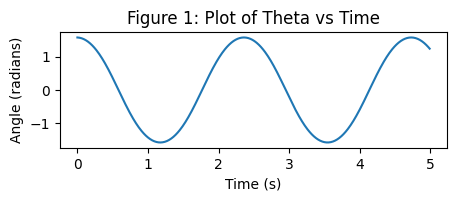

In [59]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from helper import simulate, dyn, integrate,animate_single_pend

# initial conditions
x0 = np.array([np.pi/2, 0])
T = 5.
dt = 0.01

traj = simulate(dyn, x0, [0, T], dt, integrate)
plt.rcParams["figure.figsize"] = (5,1.5)
plt.plot(np.arange(int(T/dt))*dt, traj[0], label='theta')
plt.title(r'Figure 1: Plot of Theta vs Time')
plt.xlabel("Time (s)")
plt.ylabel("Angle (radians)")
plt.show()

This plot represents a single pendulum with hanging downwards as its 0 location. It starts at a configuration of 90 degrees (horizontal), swings down past 0, and then to its other horizontal position (-pi/2) radians. The pendulum will never stop oscillating as there is no friction or damping. The plot above represents the data that we would measure from an unknown system.

# Dynamic mode decomposition to learn and predict dynamics  
Here we input our "training" data which is the angle of the pendulum as it swung for 5 seoncds (Figure 1). We use `HODMD` which is Higher Order DMD [NEED TO EXMPLAIN THIS] to fit the data and then plot the states predicted by the DMD vs the original function. Figure 2 shows that the DMD is able to learn the dynamics of the system!

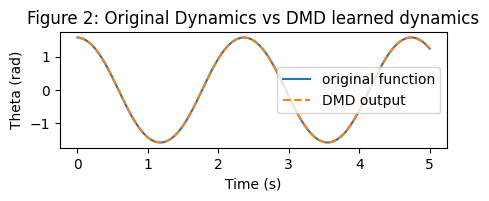

In [61]:
from pydmd import HODMD

ydata = traj[0, :]  #training data (angle)
tdata = np.linspace(0, T, int(T/dt))

hodmd = HODMD(exact=True, opt=True, d=30).fit(ydata)

hodmd.original_time['dt'] = hodmd.dmd_time['dt'] = tdata[1] - tdata[0]
hodmd.original_time['t0'] = hodmd.dmd_time['t0'] = tdata[0]
hodmd.original_time['tend'] = hodmd.dmd_time['tend'] = tdata[-1]

plt.plot(tdata, traj[0], '-', label='original function')
plt.plot(tdata, hodmd.reconstructed_data[0].real, '--', label='DMD output')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Figure 2: Original Dynamics vs DMD learned dynamics')
plt.show()


In the below block we extend the time to 50 seconds and plot the predicted dynamics from DMD. The algorithm predicts the pendulum will continue to swing back and forth infinitely, which makes sense as our model has no friction and damping.

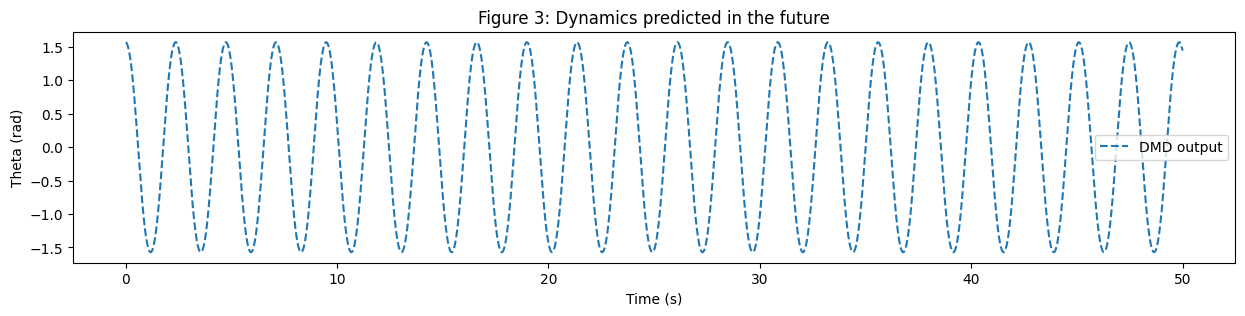

In [62]:
hodmd.dmd_time['tend'] = 50    # extend DMD 

plt.rcParams["figure.figsize"] = (15,3)
plt.plot(hodmd.dmd_timesteps, hodmd.reconstructed_data[0].real, '--', label='DMD output')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Figure 3: Dynamics predicted in the future')
plt.legend()
plt.show()

# Predicting dynamics from incomplete data

Here we will only train DMD with a quarter of a full swing's worth of data (from initial to zero configuration). In Figure 4 we see that it is able to replicate the configuration of the data it was trained on which is expected. Just as in other ML models, the error is low for training data as long as the model is sufficiently complex (which DMD is).

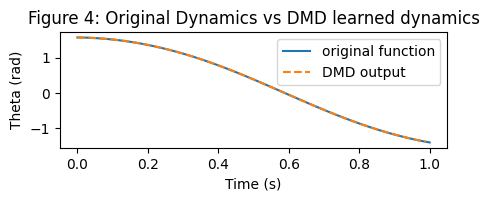

In [63]:
ydata = traj[0, :100]  #training data (angle)
T=1
tdata = np.linspace(0, T, int(T/dt))

hodmd = HODMD(exact=True, opt=True, d=30).fit(ydata)

hodmd.original_time['dt'] = hodmd.dmd_time['dt'] = tdata[1] - tdata[0]
hodmd.original_time['t0'] = hodmd.dmd_time['t0'] = tdata[0]
hodmd.original_time['tend'] = hodmd.dmd_time['tend'] = tdata[-1]

plt.rcParams["figure.figsize"] = (5,1.5)
plt.plot(tdata, ydata, '-', label='original function')
plt.plot(tdata[:-1], hodmd.reconstructed_data[0].real, '--', label='DMD output')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Figure 4: Original Dynamics vs DMD learned dynamics')
plt.show()

This cell uses the partially trained data to do prediction. The upswing immideately following the training data does a very nice job of predicting what the model will do. In fact, it works very nicely on predicing several more oscillations. However, around 15 seconds, the model becomes unstable and quickly heads towards infinity by 20 seconds. In contrast, the model trained on multiple periods was able to continue prediction for 50 seconds (and likely indefinately). This illustrates the importance of having a diverse and representative traning set in any machine learning problem! 

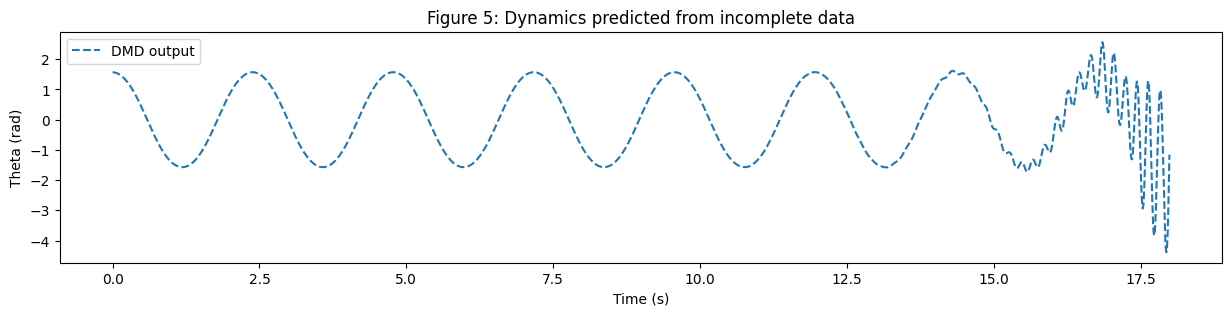

In [64]:
hodmd.dmd_time['tend'] = 18 # extend DMD 

plt.rcParams["figure.figsize"] = (15,3)
plt.plot(hodmd.dmd_timesteps[:-1], hodmd.reconstructed_data[0].real, '--', label='DMD output')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.title('Figure 5: Dynamics predicted from incomplete data')
plt.legend()
plt.show()